# Script Prep.

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive/')
  shared_drive_foldername = 'NUTRECON'
  root = '/content/drive/Shareddrives/{}/'.format(shared_drive_foldername)
  !pip install pandas==1.4.2
  print('Running Code in Colab')
except:
  root = 'D:/FV/Projects/NUTRECON/nutreconDrive/'
  print('Running Code locally')

import sys
sys.path.append(root + '1. Acquisition/notebooks')

from nutrecon import *

import numpy as np
from glob import glob
from datetime import datetime
import json

from random import shuffle, sample
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns

_v_ = Vars()

experiment_code = _v_.experiment_code
dataPath = _v_.dataPath
sequences_dataPath = _v_.sequences_dataPath
responses_dataPath = _v_.responses_dataPath

pres_order_d3_fileID = _v_.pres_order_d3_fileID
assoc3_order_fileID = _v_.assoc3_order_fileID
neuroEcon_responses_fileID = _v_.neuroEcon_d3_responses_fileID

flavorName_colName = _v_.flavorName_colName
pres_order_colName = _v_.pres_order_colName

flav_ratings_fileID = _v_.flav_ratings_d3_fileID

neurEconRealization3_fileID = _v_.neurEconRealization_d3_fileID

intensity_colName = _v_.intensity_colName
novelty_colName = _v_.novelty_colName
pleasanteness_colName = _v_.pleasanteness_colName

learn_order_fileID = _v_.learn_order_fileID
imageID_colName = _v_.imageID_colName
imageDecoder = _v_.imageDecoder


Running Code locally
Running Code locally


# 1. Flavor tasting order 


In [2]:
subject_nr = 3    # Change subject number here

# ==============================================================================

subject_code = '{}{:03d}'.format(experiment_code, subject_nr)
presentation_order_d3_df, _ = loadResponses(sequences_dataPath, pres_order_d3_fileID, subject_code)
presentation_order_d3_df.T

,Flavor,image,flavor_id,image_id
0,cashew,square,c,Image I
1,ginseng,cross,i,Image VI


## 1.1 Check ratings

In [3]:
pleas_min = 0
pleas_max = 80
df_pleas = None
df_pleas_ = None

ratings_colNames = ['User','Trial',novelty_colName, intensity_colName, pleasanteness_colName]
df_, _ = loadResponses(responses_dataPath, flav_ratings_fileID, subject_code)
if not df_ is None:
  tmp_df = presentation_order_d3_df.T
  tmp_df['Trial'] = np.arange(1,len(tmp_df)+1)
  df = tmp_df.merge(df_[ratings_colNames],
                                  left_on = 'Trial', right_on = 'Trial').drop(columns='Trial')
  df_pleas = df[(df[pleasanteness_colName] >= pleas_min) & (df[pleasanteness_colName] < pleas_max)].sort_values(by=novelty_colName, ascending = False)
  if len(df_pleas) == 0 :
    df_pleas = df.sort_values(by=[pleasanteness_colName, novelty_colName], key=abs).set_index(np.arange(1,len(df)+1))
    df_pleas['criteria'] = 'not in complience'
  else:
    df_pleas['criteria'] = 'in complience'
    flavors_ = df_pleas[flavorName_colName].to_list()
    df_ = df[~df[flavorName_colName].isin(flavors_)].sort_values(by=[pleasanteness_colName, novelty_colName], key=abs)
    df_['criteria'] = 'not in complience'
    df_pleas = pd.concat([df_pleas, df_])
  df_pleas = df_pleas.set_index(np.arange(len(df_pleas)) + 1).rename_axis('').reset_index().set_index(['criteria', ''])
  df_pleas_ = df_pleas.drop(columns = ['User'] )

df_pleas_

Flavor   image flavor_id  image_id  novelty  intensity  \
criteria                                                                   
in complience 1   cashew  square         c   Image I        3         27   
              2  ginseng   cross         i  Image VI        3         19   

                 pleasantness  
criteria                       
in complience 1            20  
              2            38

# 2. Association test order  (day 3)

In [4]:
associationTest3_df, _ = loadResponses(sequences_dataPath, assoc3_order_fileID, subject_code)
associationTest3_df.T

,Flavor,image,flavor_id,image_id
1,ginseng,cross,i,Image VI
2,cashew,square,c,Image I
3,ginseng,cross,i,Image VI
4,cashew,square,c,Image I
5,cashew,square,c,Image I
6,ginseng,cross,i,Image VI
7,ginseng,cross,i,Image VI
8,cashew,square,c,Image I
9,ginseng,cross,i,Image VI
10,ginseng,cross,i,Image VI


			Accuracy: 1.0


precision  recall  f1-score   Flavor
criteria      image_id flavor_id                                      
in compliance Image I  c                1.0     1.0       1.0   cashew
              Image VI i                1.0     1.0       1.0  ginseng

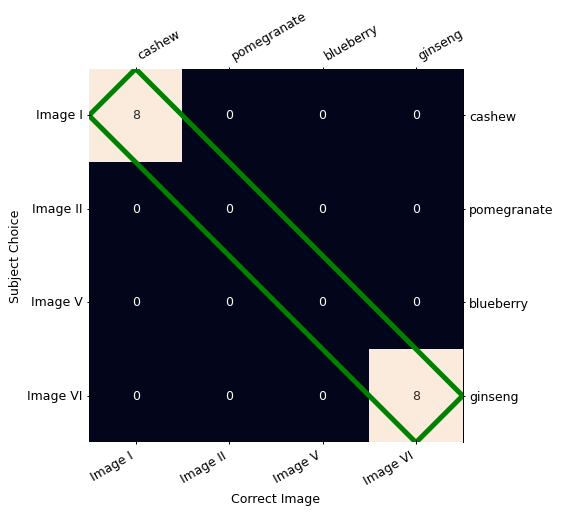

In [5]:
min_correctResp = 4
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day3_sequence = [get_key(imageDecoder,p) for p in associationTest3_df.T[imageID_colName].tolist()]
atest_day3_responses, _ = loadResponses(responses_dataPath, _v_.assoc3_fileID, subject_code)

fig, report = reportAndConfusionMatrix(atest_day3_sequence, atest_day3_responses[imageID_colName].tolist(), flavorImage_code)
#fig.savefig('atest3.png')
check_atest(report, flavorImage_code, min_correctResp)

# 3. Reward realization (day 3)

In [6]:
df, responses_path = loadResponses(responses_dataPath, neuroEcon_responses_fileID, subject_code)

seed = int(responses_path.split('_')[-1].split('.')[0])
rng = np.random.default_rng(int(responses_path.split('_')[-1].split('.')[0]))

df_clean = df[df['choice'] != 0]

mix_yogurt_df = df_clean[df_clean['Trial Type'] == 'mixed_yogurt']
st_mt_df = df_clean[df_clean['Trial Type'] != 'mixed_yogurt']

realizationTrials_df  = pd.concat([mix_yogurt_df.sample(1), st_mt_df.groupby(['Trial Type', 'lottery type']).sample(1)]).reset_index(drop = True)

realizationResults_df = realizationTrials_df.apply(lambda row: realizeChoices(row,rng), axis = 1)
realizationResults_df = save_json(realizationResults_df, subject_code, neurEconRealization3_fileID , sequences_dataPath)
realizationResults_df[['Trial Type', 'reference type', 'lottery type', 'reference qt', 'lottery qt', 'reference p', 'lottery p', 'choice', 'reward Qt.',	'reward description']]


File already exists. Created on 2022-12-14 11:07:23


,Trial Type,reference type,lottery type,reference qt,lottery qt,reference p,lottery p,choice,reward Qt.,reward description
0,mixed_yogurt,C+,C-,80.0,80,0.5,0.50,1,0,You got nothing
1,mixed,money,C+,0.2,150,1.0,0.22,2,0,You got nothing
2,mixed,money,C-,0.2,150,1.0,0.75,2,150,mL of cashew yogurt
3,same,C+,C+,20.0,200,1.0,0.22,2,0,You got nothing
4,same,C-,C-,20.0,120,1.0,0.38,1,20,mL of cashew yogurt
5,same,money,money,1.0,1,1.0,0.50,1,1,€


___

# (in preparation...) 

com alphas negativos, EU diminui com o aumento da reward - faz sentido com o report da pessoa

quanto maior o valor absoluto do alpha, maior a diferença nas EU

___

cuspir total de money realization